# Genotype-Phenotype Analysis for Stolerman Neurodevelopmental Syndrome (OMIM #618505)

In this notebook, we will conduct a genotype-phenotype analysis for **Stolerman Neurodevelopmental Syndrome (OMIM #6618505)**, a rare developmental disorder caused by pathogenic variants in the *KDM6B* gene. This syndrome is characterized by motor and speech delay, mildly impaired intellectual development (in most patients), learning difficulties, and behavioral abnormalities, including autism spectrum disorder. Psychosis is observed in a small percentage of individuals over the age of 12 years. Most individuals have nonspecific and mild dysmorphic facial features without a common gestalt. A subset of patients may have involvement of other organ systems, including gastrointestinal with poor early feeding or gastroesophageal reflux, distal skeletal anomalies, and congenital heart defects. Most mutations occur de novo, but rare autosomal dominant inheritance with incomplete penetrance has been observed 

First, do the first preprocessing steps, loading all the data, validating it, and generating a nice figure for the variants. This will help us to generate hypotheses about possible genotype/phenotype correlations we would like to investigate. 

In [3]:
import hpotk
store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-07-01')

cohort_name = 'KDM6B'
tx_id = 'NM_001348716.2'
px_id = 'NP_001335645.1'

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
len(phenopackets)

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

from gpsea.view import CohortViewable
viewer = CohortViewable(hpo)
report = viewer.process(cohort=cohort, transcript_id=tx_id)
report

Individuals Processed: 100%|██████████| 73/73 [00:00<00:00, 528.53individuals/s]
Validated under permissive policy
No errors or warnings were found


HPO Term,ID,Seen in n individuals
Delayed speech and language development,HP:0000750,61
Motor delay,HP:0001270,57
Autistic behavior,HP:0000729,39
Hypotonia,HP:0001252,32
Feeding difficulties,HP:0011968,22
Joint hypermobility,HP:0001382,20
Macrocephaly,HP:0000256,15
Sleep abnormality,HP:0002360,15
"Intellectual disability, mild",HP:0001256,13
Attention deficit hyperactivity disorder,HP:0007018,13


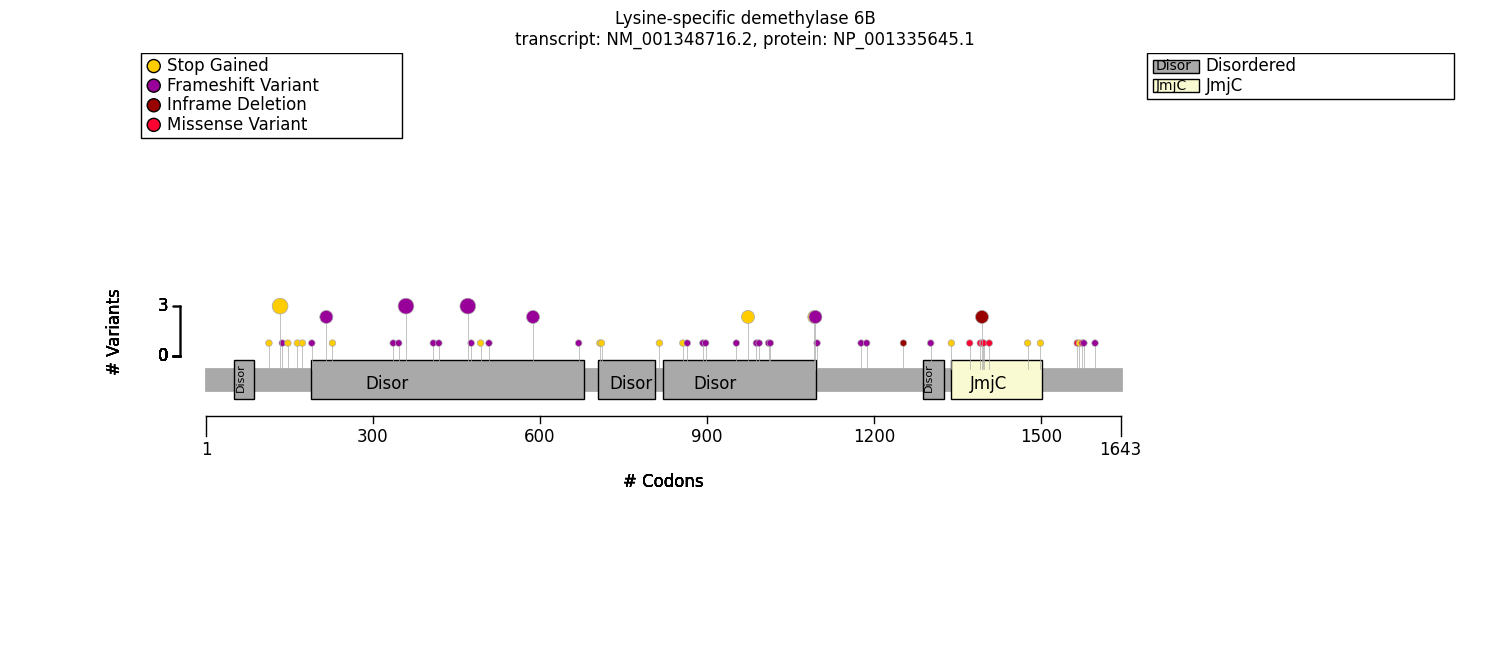

Variant key,Variant (cDNA),Variant (protein),Effects,Count
17_7847703_7847705_CCT_C,c.1416_1417del,p.Cys473SerfsTer36,frameshift,3
17_7847275_7847279_TAGAG_T,c.1085_1088del,p.Glu362AlafsTer124,frameshift,3
17_7846244_7846244_C_T,c.403C>T,p.Arg135Ter,stop gained,3
17_7849569_7849569_C_A,c.3281C>A,p.Ser1094Ter,stop gained,2
17_7851969_7851972_ACTT_A,c.4187_4189del,p.Phe1396del,inframe deletion,2
17_7849211_7849211_C_T,c.2923C>T,p.Arg975Ter,stop gained,2
17_7848054_7848055_GC_G,c.1769del,p.Pro590GlnfsTer13,frameshift,2
17_7846682_7846684_CAG_C,c.654_655del,p.Glu220GlyfsTer16,frameshift,2
17_7849573_7849577_TAGTG_T,c.3288_3291del,p.Ser1096ArgfsTer7,frameshift,2
17_7851749_7851749_T_C,c.4118T>C,p.Met1373Thr,missense,1


In [4]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(tx_id)
protein_meta = pms.annotate(px_id)

from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()
fig.savefig('kdm6b_protein_diagram.png')
plt.show()

from gpsea.view import CohortVariantViewer
viewer = CohortVariantViewer(tx_id=tx_id)
report = viewer.process(cohort=cohort)
report

Lets investigate the JmjC domain versus the rest of the cohort. This region seems to start at 7851650 and end at 7852530, so we will filter the genomic coordinates based on that.

In [7]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

gt_predicate = monoallelic_predicate(
    a_predicate=VariantPredicates.region(Region(7851650, 7852530), tx_id),
    b_predicate=~VariantPredicates.region(Region(7851650, 7852530), tx_id),
    names=('JmjC domain', 'Rest of the cohort')
)
gt_predicate.display_question()

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=2,
)

from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()

from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

len(result.phenotypes)

from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_report = mtc_viewer.process(result)
mtc_report


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,48
HMF05,Skipping term because one genotype had zero observations,74
HMF06,Skipping term with less than 7 observations (not powered for 2x2),184
HMF07,Skipping non phenotype term,2
HMF08,Skipping general term,81


In [8]:

from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Empty DataFrame
Columns: [(JmjC domain, Count), (JmjC domain, Percent), (Rest of the cohort, Count), (Rest of the cohort, Percent), (, p values)]
Index: []